## Similarity with IDF-w2v brand color and image features

### Lets check similarity with IDF-w2v brand color and image features. We will take files processed in previous ipython notebook

* Construct IDF weighted W2V, lets have brand which is constructed using one hot encoding, also have color feature build using one hot encoding, also have image features. We'll give weight for test features, brand features, color features and image features also. Lets try out different weights and try out weighted euclidian distance base similarity, using above features of text, brand, color and images

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
#import PIL as PIL
import pandas as pd
import pickle

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
data = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/Applied_AI_Workshop_Code_Data/pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


## IDF features

In [0]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

## IDF W2V

In [7]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


'''
#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)
'''

"\n#if you do NOT have RAM >= 12GB, use the code below.\nwith open('word2vec_model', 'rb') as handle:\n    model = pickle.load(handle)\n"

In [6]:
# Downloaded google w2v file from below commands
#!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
#!gunzip GoogleNews-vectors-negative300.bin.gz

--2019-05-14 09:08:42--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.239.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.239.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  64.8MB/s    in 24s     

2019-05-14 09:09:07 (64.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
# Utility functions

#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()
    
  

In [0]:
# vocab = stores all the words that are there in google w2v model
vocab = model.wv.vocab.keys() # if you are using Google word2Vec

#vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

### IDF weighted Word2Vec features

In [0]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [11]:
w2v_title_weight.shape

(16042, 300)

### Brand and color features

In [0]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
#types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

#type_vectorizer = CountVectorizer()
#type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, color_features)).tocsr()

In [13]:
extra_features.shape

(16042, 5680)

### Load image features

In [0]:
from scipy import sparse
bottleneck_features_train = np.load('/content/gdrive/My Drive/Colab Notebooks/Applied_AI_Workshop_Code_Data/16k_data_cnn_features.npy')
bottleneck_features_train = sparse.csr_matrix(bottleneck_features_train)
asins = np.load('/content/gdrive/My Drive/Colab Notebooks/Applied_AI_Workshop_Code_Data/16k_data_cnn_feature_asins.npy')

In [15]:
bottleneck_features_train.shape

(16042, 25088)

In [16]:
print(data.columns)
data.head()

Index(['asin', 'brand', 'color', 'medium_image_url', 'product_type_name',
       'title', 'formatted_price'],
      dtype='object')


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [17]:
#df_features = pd.DataFrame()
#df_features['asin'] = data['asin']
data = data.join(pd.DataFrame(w2v_title_weight))
data = data.join(pd.DataFrame(extra_features.toarray()), lsuffix='_left')
data.shape

(16042, 5987)

In [18]:
df_image_features = pd.DataFrame()
df_image_features['asin'] = asins
df_image_features = df_image_features.join(pd.DataFrame(bottleneck_features_train.toarray()))
df_image_features.shape

(16042, 25089)

In [19]:
data = pd.merge(data, df_image_features , on='asin', how='inner')
data.shape

(16042, 31075)

In [0]:
bottleneck_features_train = None
asins = None
bottleneck_features_train = data[data.columns[5987:]]

In [0]:
bottleneck_features_train = bottleneck_features_train.to_numpy()

In [29]:
type(bottleneck_features_train)

numpy.ndarray

In [40]:
len(bottleneck_features_train[12566].reshape(1,-1))

1

In [50]:
img_feat_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[12566].reshape(1,-1))
img_feat_dist

array([[58.98553 ],
       [61.087532],
       [58.07511 ],
       ...,
       [53.814053],
       [57.479626],
       [54.41605 ]], dtype=float32)

In [36]:
pairwise_distances(bottleneck_features_train, bottleneck_features_train[12566].reshape(1,-1))

array([[58.98553 ],
       [61.087532],
       [58.07511 ],
       ...,
       [53.814053],
       [57.479626],
       [54.41605 ]], dtype=float32)

In [0]:
#img_feat_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

In [0]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
df_asins = list(data['asin'])

In [0]:
def idf_w2v_brand_color_image(doc_id, w1, w2, w3, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
       
    
    #doc_id = asins.index(df_asins[doc_id])
    #doc_id = np.where(asins==df_asins[doc_id])
    print("doc_id: ", doc_id)    
    
    img_feat_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    
    print("idf_w2v_dist: ", len(idf_w2v_dist))    
    print("ex_feat_dist: ", len(ex_feat_dist)) 
    print("img_feat_dist: ", len(img_feat_dist))    
    
    #pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3 * img_feat_dist)/float(w1 + w2 + w3)
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3 )/float(w1 + w2 )
    #pairwise_dist   = ex_feat_dist
    #pairwise_dist   = idf_w2v_dist
    
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    print("indices: ", indices)
    print("pdists: ", pdists)
    
    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    print("pairwise_dist: ", df_indices)

   
    
    #"""
    for i in range(0, len(indices)):
        #heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        url_ = data['medium_image_url'].loc[df_indices[i]]
        Image(url=url_, embed=True)
        display(Image(url=url_, embed=True))
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('title :',data['title'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('Color :',data['color'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)
     

## Similarity using idf w2v, brand, color and image with no weightage

doc_id:  12566
idf_w2v_dist:  16042
ex_feat_dist:  16042
img_feat_dist:  16042
indices:  [12566 14072 14089 14002  7105  9337 12934 12065 12107 10569 12540 13041
  7726  8581 11150 15168  2849  7482  7403  2795]
pdists:  [0.5        1.15288001 1.50170319 1.73728342 1.76862271 1.77334846
 1.78186865 1.79474891 1.82363589 1.82935674 1.84993852 1.86498989
 1.90839024 1.98036833 1.98328187 1.99087669 1.99646236 2.00195028
 2.00343712 2.01422693]
pairwise_dist:  [12566, 14072, 14089, 14002, 7105, 9337, 12934, 12065, 12107, 10569, 12540, 13041, 7726, 8581, 11150, 15168, 2849, 7482, 7403, 2795]


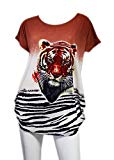

ASIN : B00JXQB5FQ
title : burnt umber tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 0.5


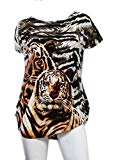

ASIN : B00JXQCWTO
title : brown  white tiger tshirt tiger stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 1.1528800129890442


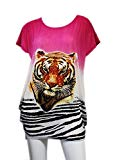

ASIN : B00JXQASS6
title : pink tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 1.5017031850237514


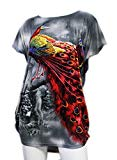

ASIN : B00JXQCFRS
title : grey  red peacock print tshirt  l 
Brand : Si Row
Color : Grey
euclidean distance from input : 1.7372834207434322


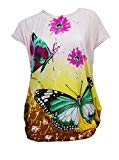

ASIN : B00JXQBBMI
title : yellow  pink butterfly color burst tshirt xl  xxl 
Brand : Si Row
Color : Yellow
euclidean distance from input : 1.7686227085013058


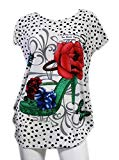

ASIN : B00JXQABB0
title : red rose bud  heel dalmatian tshirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.7733484627623226


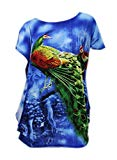

ASIN : B00JXQC8L6
title : blue peacock print tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 1.7818686487097408


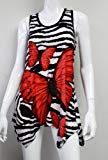

ASIN : B00JV63CW2
title : red butterfly black  white tank top xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.7947489144224789


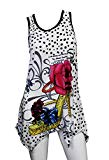

ASIN : B00JXQAX2C
title : pink rose bud  heel dalmatian tank top xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 1.8236358882803585


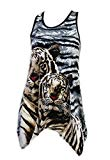

ASIN : B00JXQAFZ2
title : grey  white tiger tank top tiger stripes xl  xxl 
Brand : Si Row
Color : Grey
euclidean distance from input : 1.8293567420859005


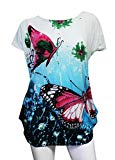

ASIN : B00JXQC0C8
title : blue  green butterfly color burst tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 1.8499385239500667


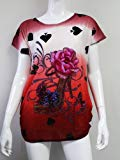

ASIN : B00JV63QQE
title : red  pink floral heel sleeveless shirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.8649898888487484


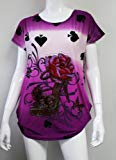

ASIN : B00JV63VC8
title : purple floral heel sleeveless shirt xl  xxl 
Brand : Si Row
Color : Purple
euclidean distance from input : 1.908390236081567


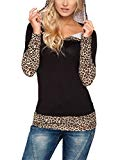

ASIN : B01KJUM6JI
title : yabina womens pullover leopard print long sleeve hoodie us10 brown 
Brand : YABINA
Color : Brown
euclidean distance from input : 1.9803683317171779


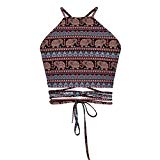

ASIN : B01ER184O6
title : gupobou168 womens girls lady boho elephant stripes bandage tank top one size 
Brand : GuPoBoU168
Color : Brown
euclidean distance from input : 1.9832818663584437


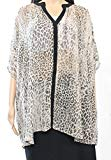

ASIN : B074MH886R
title : bobeau black animal print sheer womens plus blouse brown 1x 
Brand : Bobeau
Color : Brown
euclidean distance from input : 1.990876690195724


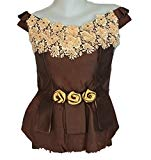

ASIN : B074J48RGW
title : dark brown lao laos sleeveless blouse vneckline tops size 34 sl34b 
Brand : Nanon
Color : Brown
euclidean distance from input : 1.9964623606669154


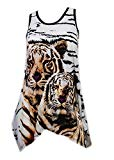

ASIN : B00JXQAO94
title : black  white tiger tank top tiger stripes  l 
Brand : Si Row
Color : White
euclidean distance from input : 2.001950276078668


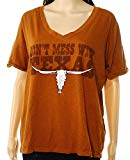

ASIN : B07317428N
title : retro brand womens vneck texas graphic tee tshirt brown xs 
Brand : Retro
Color : Brown
euclidean distance from input : 2.003437117384597


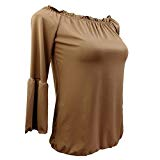

ASIN : B07515JFBF
title : magideal womens stretchy loose fit scoop neck pullover tops blouses sxl  brown xl 
Brand : MagiDeal
Color : Brown
euclidean distance from input : 2.0142269289957726


In [64]:
idf_w2v_brand_color_image(12566, 1, 1, 1, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

## Similarity using idf w2v, brand, color and image with similar weightage

doc_id:  12566
idf_w2v_dist:  16042
ex_feat_dist:  16042
img_feat_dist:  16042
indices:  [12566 14072 14089 14002  7105  9337 12934 12065 12107 10569 12540 13041
  7726  8581 11150 15168  2849  7482  7403  2795]
pdists:  [0.5        1.15288    1.50170319 1.73728342 1.76862268 1.77334847
 1.78186865 1.79474893 1.82363586 1.82935677 1.84993854 1.8649899
 1.90839024 1.98036833 1.98328185 1.99087668 1.99646235 2.00195026
 2.00343709 2.01422692]
pairwise_dist:  [12566, 14072, 14089, 14002, 7105, 9337, 12934, 12065, 12107, 10569, 12540, 13041, 7726, 8581, 11150, 15168, 2849, 7482, 7403, 2795]


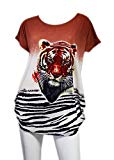

ASIN : B00JXQB5FQ
title : burnt umber tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 0.5


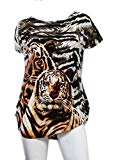

ASIN : B00JXQCWTO
title : brown  white tiger tshirt tiger stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 1.1528800010681153


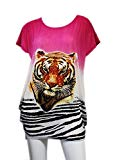

ASIN : B00JXQASS6
title : pink tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 1.501703190984216


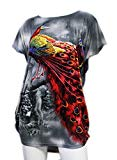

ASIN : B00JXQCFRS
title : grey  red peacock print tshirt  l 
Brand : Si Row
Color : Grey
euclidean distance from input : 1.7372834207434322


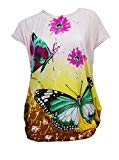

ASIN : B00JXQBBMI
title : yellow  pink butterfly color burst tshirt xl  xxl 
Brand : Si Row
Color : Yellow
euclidean distance from input : 1.768622684659448


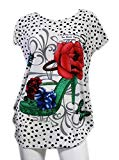

ASIN : B00JXQABB0
title : red rose bud  heel dalmatian tshirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.7733484746832517


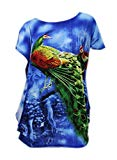

ASIN : B00JXQC8L6
title : blue peacock print tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 1.7818686487097408


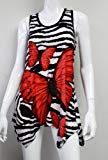

ASIN : B00JV63CW2
title : red butterfly black  white tank top xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.794748926343408


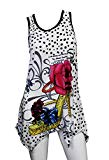

ASIN : B00JXQAX2C
title : pink rose bud  heel dalmatian tank top xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 1.8236358644385007


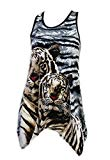

ASIN : B00JXQAFZ2
title : grey  white tiger tank top tiger stripes xl  xxl 
Brand : Si Row
Color : Grey
euclidean distance from input : 1.8293567659277585


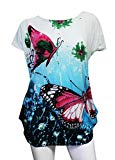

ASIN : B00JXQC0C8
title : blue  green butterfly color burst tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 1.8499385358709959


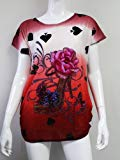

ASIN : B00JV63QQE
title : red  pink floral heel sleeveless shirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.8649899007696775


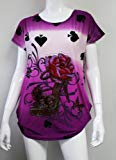

ASIN : B00JV63VC8
title : purple floral heel sleeveless shirt xl  xxl 
Brand : Si Row
Color : Purple
euclidean distance from input : 1.908390236081567


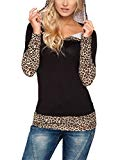

ASIN : B01KJUM6JI
title : yabina womens pullover leopard print long sleeve hoodie us10 brown 
Brand : YABINA
Color : Brown
euclidean distance from input : 1.9803683317171779


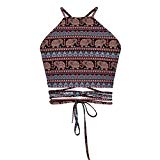

ASIN : B01ER184O6
title : gupobou168 womens girls lady boho elephant stripes bandage tank top one size 
Brand : GuPoBoU168
Color : Brown
euclidean distance from input : 1.9832818544375148


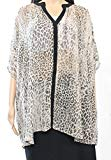

ASIN : B074MH886R
title : bobeau black animal print sheer womens plus blouse brown 1x 
Brand : Bobeau
Color : Brown
euclidean distance from input : 1.990876678274795


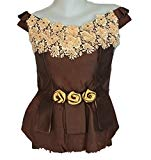

ASIN : B074J48RGW
title : dark brown lao laos sleeveless blouse vneckline tops size 34 sl34b 
Brand : Nanon
Color : Brown
euclidean distance from input : 1.9964623487459865


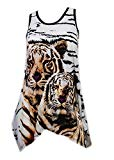

ASIN : B00JXQAO94
title : black  white tiger tank top tiger stripes  l 
Brand : Si Row
Color : White
euclidean distance from input : 2.001950264157739


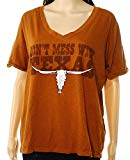

ASIN : B07317428N
title : retro brand womens vneck texas graphic tee tshirt brown xs 
Brand : Retro
Color : Brown
euclidean distance from input : 2.0034370935427392


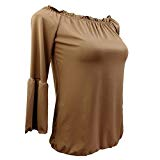

ASIN : B07515JFBF
title : magideal womens stretchy loose fit scoop neck pullover tops blouses sxl  brown xl 
Brand : MagiDeal
Color : Brown
euclidean distance from input : 2.014226917074844


In [65]:
idf_w2v_brand_color_image(12566, 5, 5, 5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

## Similarity using idf w2v, brand, color and image with more weightage to idf w2v

doc_id:  12566
idf_w2v_dist:  16042
ex_feat_dist:  16042
img_feat_dist:  16042
indices:  [12566 14089 14002 11092 12949  7105 13225  9666  9337  2197  9518  9947
  6100  9681 13759  7428 11753  4218 12934  3483]
pdists:  [0.01904762 0.64752713 1.09625135 1.09978336 1.15002147 1.15594526
 1.16032769 1.16090419 1.16494671 1.16532263 1.16686093 1.16707448
 1.16806761 1.16986077 1.17072954 1.17364135 1.17570064 1.17762797
 1.18117567 1.18536127]
pairwise_dist:  [12566, 14089, 14002, 11092, 12949, 7105, 13225, 9666, 9337, 2197, 9518, 9947, 6100, 9681, 13759, 7428, 11753, 4218, 12934, 3483]


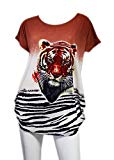

ASIN : B00JXQB5FQ
title : burnt umber tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 0.01904761904761905


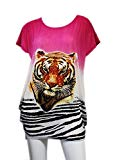

ASIN : B00JXQASS6
title : pink tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 0.6475271315973795


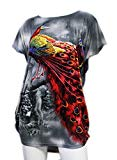

ASIN : B00JXQCFRS
title : grey  red peacock print tshirt  l 
Brand : Si Row
Color : Grey
euclidean distance from input : 1.096251351509954


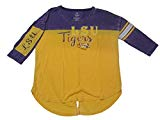

ASIN : B073R5Q8HD
title : lsu tigers colosseum womens yellow  purple slit back 12 sleeves tshirt 
Brand : Colosseum
Color : Yellow
euclidean distance from input : 1.0997833622330628


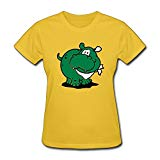

ASIN : B01EJS5H06
title : vansty hippo naughty round neck tshirt women yellow size xl 
Brand : Vansty
Color : Gold
euclidean distance from input : 1.1500214720033382


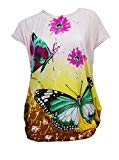

ASIN : B00JXQBBMI
title : yellow  pink butterfly color burst tshirt xl  xxl 
Brand : Si Row
Color : Yellow
euclidean distance from input : 1.1559452602013602


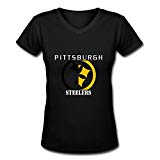

ASIN : B01LX6H2P7
title : steelers logo 2016 ladys hot v neck shirt black xl 
Brand : BOBOB
Color : Black
euclidean distance from input : 1.1603276941015526


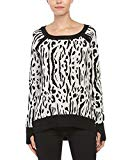

ASIN : B01MPX3HPW
title : pam  gela womens wool tiger intarsia highlow sweater p white 
Brand : Pam & Gela
Color : White
euclidean distance from input : 1.1609041920856573


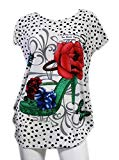

ASIN : B00JXQABB0
title : red rose bud  heel dalmatian tshirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.16494671051293


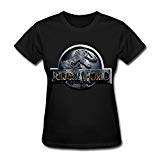

ASIN : B016OPN4OI
title : tike womens jurassic dino world 4 tshirt color black size xl 
Brand : TIKE Fashions
Color : Black
euclidean distance from input : 1.1653226287718552


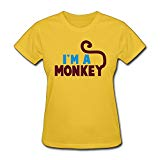

ASIN : B01EFSLO8Y
title : vansty im monkey cute tail oneck shirt lady yellow size xl 
Brand : Vansty
Color : Gold
euclidean distance from input : 1.1668609262909126


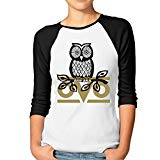

ASIN : B01L8L73M2
title : hotgirl4 women owl ovo raglan triblend sleeve color black xl 
Brand : Hotgirl4 Raglan Design
Color : Black
euclidean distance from input : 1.167074481725732


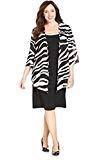

ASIN : B01BO1XRK8
title : le bos plus size zebra print jacket black 14w 
Brand : Le Bos
Color : Black
euclidean distance from input : 1.1680676122632987


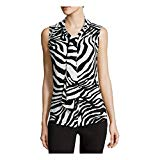

ASIN : B06XBY5QXL
title : liz claiborne zebra fronttie top size xl 
Brand : Liz Claiborne
Color : Crema Multi/Black
euclidean distance from input : 1.1698607672172665


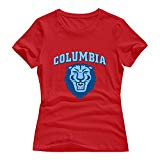

ASIN : B017Q26FDA
title : red roundneck columbia lions shirts women size xl 
Brand : Tavil
Color : Red
euclidean distance from input : 1.1707295379445584


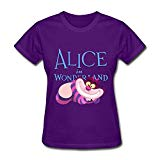

ASIN : B015F1AKUI
title : zeko womens tshirt alice wonderland cheshire cat size l purple 
Brand : ZEKO
Color : Purple
euclidean distance from input : 1.1736413508630852


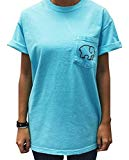

ASIN : B01I53HU6K
title : ouxiuli womens elephant print pocket crew neck casual tshirt sky blue xs 
Brand : ouxiuli
Color : Sky Blue
euclidean distance from input : 1.1757006398395635


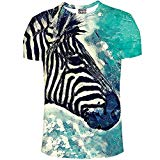

ASIN : B072R2JXKW
title : womens zebra watercolor tshirt  short sleeve  frontback print  xl 
Brand : WHAT ON EARTH
Color : Multicolored
euclidean distance from input : 1.177627968867659


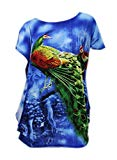

ASIN : B00JXQC8L6
title : blue peacock print tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 1.181175667916204


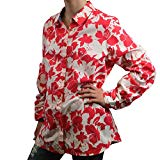

ASIN : B0711NGTQM
title : tommy hilfiger floralprint buttonfront shir rouge red xl 
Brand : THILFIGER RTW
Color : Medium Red
euclidean distance from input : 1.1853612684863346


In [66]:
idf_w2v_brand_color_image(12566, 100, 5, 2, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

## Similarity using idf w2v, brand, color and image with more weightage to brand and color

doc_id:  12566
idf_w2v_dist:  16042
ex_feat_dist:  16042
img_feat_dist:  16042
indices:  [12566 14072 14089 14002  7105  9337 12934 12065 12107 10569 12540 13041
  7726  7482  7330 14790  8581 11150 15168  2849]
pdists:  [0.01904762 0.08122667 1.39397448 1.41641069 1.41939538 1.41984546
 1.4206569  1.4218836  1.42463473 1.42517958 1.42713975 1.42857321
 1.43270658 1.44161706 1.44803885 1.45413276 1.72712867 1.72740615
 1.72812946 1.72866143]
pairwise_dist:  [12566, 14072, 14089, 14002, 7105, 9337, 12934, 12065, 12107, 10569, 12540, 13041, 7726, 7482, 7330, 14790, 8581, 11150, 15168, 2849]


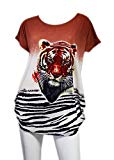

ASIN : B00JXQB5FQ
title : burnt umber tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 0.01904761904761905


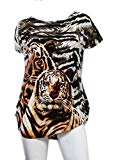

ASIN : B00JXQCWTO
title : brown  white tiger tshirt tiger stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 0.08122666676839192


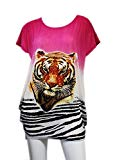

ASIN : B00JXQASS6
title : pink tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 1.3939744793836781


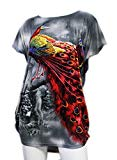

ASIN : B00JXQCFRS
title : grey  red peacock print tshirt  l 
Brand : Si Row
Color : Grey
euclidean distance from input : 1.4164106917416985


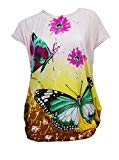

ASIN : B00JXQBBMI
title : yellow  pink butterfly color burst tshirt xl  xxl 
Brand : Si Row
Color : Yellow
euclidean distance from input : 1.419395383543224


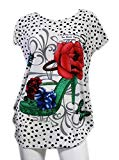

ASIN : B00JXQABB0
title : red rose bud  heel dalmatian tshirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.4198454587835863


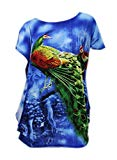

ASIN : B00JXQC8L6
title : blue peacock print tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 1.420656903928966


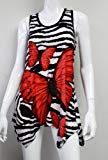

ASIN : B00JV63CW2
title : red butterfly black  white tank top xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.4218835970369343


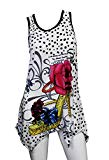

ASIN : B00JXQAX2C
title : pink rose bud  heel dalmatian tank top xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 1.4246347339983718


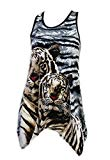

ASIN : B00JXQAFZ2
title : grey  white tiger tank top tiger stripes xl  xxl 
Brand : Si Row
Color : Grey
euclidean distance from input : 1.4251795817592534


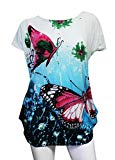

ASIN : B00JXQC0C8
title : blue  green butterfly color burst tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 1.427139750325276


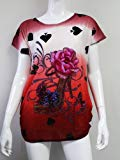

ASIN : B00JV63QQE
title : red  pink floral heel sleeveless shirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 1.4285732136489602


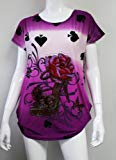

ASIN : B00JV63VC8
title : purple floral heel sleeveless shirt xl  xxl 
Brand : Si Row
Color : Purple
euclidean distance from input : 1.432706578916759


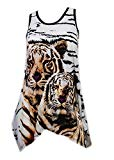

ASIN : B00JXQAO94
title : black  white tiger tank top tiger stripes  l 
Brand : Si Row
Color : White
euclidean distance from input : 1.4416170577811565


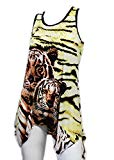

ASIN : B00JXQAUWA
title : yellow tiger tank top tiger stripes  l 
Brand : Si Row
Color : Yellow
euclidean distance from input : 1.4480388463146852


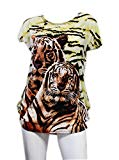

ASIN : B00JXQCUIC
title : yellow tiger tshirt tiger stripes  l 
Brand : Si Row
Color : Yellow
euclidean distance from input : 1.4541327616182333


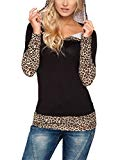

ASIN : B01KJUM6JI
title : yabina womens pullover leopard print long sleeve hoodie us10 brown 
Brand : YABINA
Color : Brown
euclidean distance from input : 1.7271286670115726


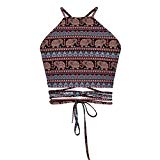

ASIN : B01ER184O6
title : gupobou168 womens girls lady boho elephant stripes bandage tank top one size 
Brand : GuPoBoU168
Color : Brown
euclidean distance from input : 1.7274061453658904


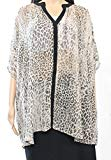

ASIN : B074MH886R
title : bobeau black animal print sheer womens plus blouse brown 1x 
Brand : Bobeau
Color : Brown
euclidean distance from input : 1.7281294619218217


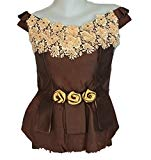

ASIN : B074J48RGW
title : dark brown lao laos sleeveless blouse vneckline tops size 34 sl34b 
Brand : Nanon
Color : Brown
euclidean distance from input : 1.7286614305381258


In [67]:
idf_w2v_brand_color_image(12566, 5, 100, 2, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

## Similarity using idf w2v, brand, color and image with more weightage to images

doc_id:  12566
idf_w2v_dist:  16042
ex_feat_dist:  16042
img_feat_dist:  16042
indices:  [12566 14072 14089 14002  7105  9337 12934 12065 12107 10569 12540 13041
  7726  7482  7330 14790  8581 11150 15168  2849  7403  2795  5231 13869
  4412 13905 10204  3115  2097 13275 12633  7111  9243 12381 10274  9519
  8635  6775 14817  4181 10209 13237  6070  1779  9876  6417  8656  3725
  7074  5707  7124 12466  7992 15712 12276 15028 11526 10062  9821 10033
  2126  3641  8043 10995  2821  8782   293 10491 11489 11137  4144 13641
  2046 14952  8910   770  7578  5404  6774 15393  3907  4028 14697  3014
  8122   687 14889 15943 13019 10139 10842 13270   350  5256  5784 12958
 14703 16027 12644 14993]
pdists:  [2.5        2.82644001 3.70795837 3.82574849 3.84141814 3.84378101
 3.84804111 3.85448124 3.86892473 3.87178515 3.88207604 3.88960173
 3.9113019  3.95808192 3.9917963  4.02378936 4.10620957 4.10766634
 4.11146375 4.11425658 4.11774396 4.12313887 4.12520745 4.12736907
 4.12922781 4.12929868 4

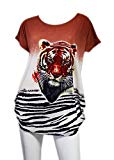

ASIN : B00JXQB5FQ
title : burnt umber tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 2.5


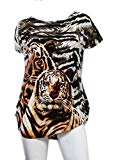

ASIN : B00JXQCWTO
title : brown  white tiger tshirt tiger stripes xl  xxl 
Brand : Si Row
Color : Brown
euclidean distance from input : 2.826440006494522


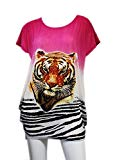

ASIN : B00JXQASS6
title : pink tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 3.7079583736984234


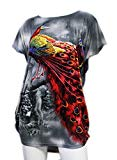

ASIN : B00JXQCFRS
title : grey  red peacock print tshirt  l 
Brand : Si Row
Color : Grey
euclidean distance from input : 3.825748491558264


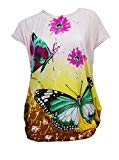

ASIN : B00JXQBBMI
title : yellow  pink butterfly color burst tshirt xl  xxl 
Brand : Si Row
Color : Yellow
euclidean distance from input : 3.8414181354372006


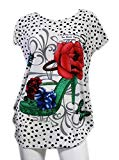

ASIN : B00JXQABB0
title : red rose bud  heel dalmatian tshirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 3.843781012567709


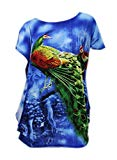

ASIN : B00JXQC8L6
title : blue peacock print tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 3.848041105541418


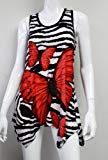

ASIN : B00JV63CW2
title : red butterfly black  white tank top xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 3.854481238397787


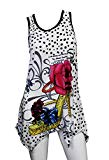

ASIN : B00JXQAX2C
title : pink rose bud  heel dalmatian tank top xl  xxl 
Brand : Si Row
Color : Pink
euclidean distance from input : 3.868924725326727


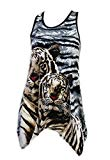

ASIN : B00JXQAFZ2
title : grey  white tiger tank top tiger stripes xl  xxl 
Brand : Si Row
Color : Grey
euclidean distance from input : 3.871785152229498


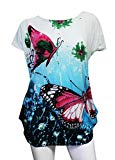

ASIN : B00JXQC0C8
title : blue  green butterfly color burst tshirt  l 
Brand : Si Row
Color : Blue
euclidean distance from input : 3.882076043161581


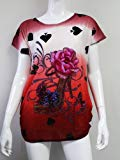

ASIN : B00JV63QQE
title : red  pink floral heel sleeveless shirt xl  xxl 
Brand : Si Row
Color : Red
euclidean distance from input : 3.889601725610922


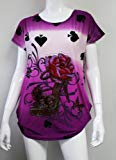

ASIN : B00JV63VC8
title : purple floral heel sleeveless shirt xl  xxl 
Brand : Si Row
Color : Purple
euclidean distance from input : 3.911301899227331


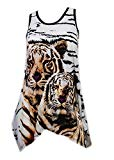

ASIN : B00JXQAO94
title : black  white tiger tank top tiger stripes  l 
Brand : Si Row
Color : White
euclidean distance from input : 3.9580819192258816


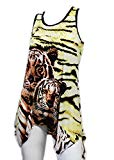

ASIN : B00JXQAUWA
title : yellow tiger tank top tiger stripes  l 
Brand : Si Row
Color : Yellow
euclidean distance from input : 3.9917963030664425


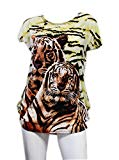

ASIN : B00JXQCUIC
title : yellow tiger tshirt tiger stripes  l 
Brand : Si Row
Color : Yellow
euclidean distance from input : 4.0237893643705345


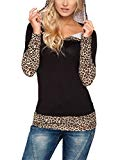

ASIN : B01KJUM6JI
title : yabina womens pullover leopard print long sleeve hoodie us10 brown 
Brand : YABINA
Color : Brown
euclidean distance from input : 4.106209569643028


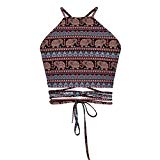

ASIN : B01ER184O6
title : gupobou168 womens girls lady boho elephant stripes bandage tank top one size 
Brand : GuPoBoU168
Color : Brown
euclidean distance from input : 4.107666336963661


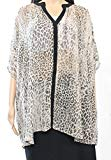

ASIN : B074MH886R
title : bobeau black animal print sheer womens plus blouse brown 1x 
Brand : Bobeau
Color : Brown
euclidean distance from input : 4.111463748882301


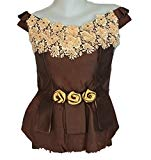

ASIN : B074J48RGW
title : dark brown lao laos sleeveless blouse vneckline tops size 34 sl34b 
Brand : Nanon
Color : Brown
euclidean distance from input : 4.114256584117896


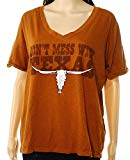

ASIN : B07317428N
title : retro brand womens vneck texas graphic tee tshirt brown xs 
Brand : Retro
Color : Brown
euclidean distance from input : 4.117743962476737


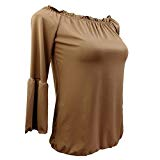

ASIN : B07515JFBF
title : magideal womens stretchy loose fit scoop neck pullover tops blouses sxl  brown xl 
Brand : MagiDeal
Color : Brown
euclidean distance from input : 4.123138868282325


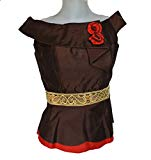

ASIN : B074J7BCYM
title : dark brown lao laos laotian sleeveless blouse classic neckline size 36 sl36f 
Brand : Nanon
Color : Brown
euclidean distance from input : 4.125207447479255


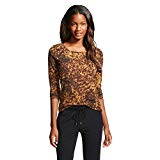

ASIN : B01M5KO072
title : merona womens vintage slub scoop tee xs brown 
Brand : Merona
Color : Brown
euclidean distance from input : 4.127369069526679


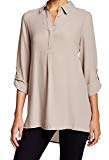

ASIN : B074NBD9C7
title : pleione mocha womens small collared hilow blouse brown 
Brand : Pleione
Color : Brown
euclidean distance from input : 4.1292278105716775


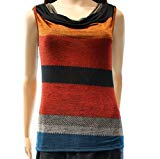

ASIN : B074P8YWV4
title : bobeau womens small petite striped tank cami top brown ps 
Brand : Bobeau
Color : Brown
euclidean distance from input : 4.1292986804943155


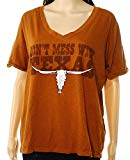

ASIN : B072Y1RTRY
title : retro brand womens small texas graphic tee tshirt brown 
Brand : Retro
Color : Brown
euclidean distance from input : 4.131289356420524


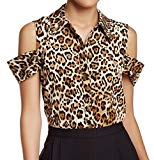

ASIN : B01LZ7BQ4H
title : wayf womens button cold shoulder leopard blouse brown xs 
Brand : WAYF
Color : Brown
euclidean distance from input : 4.131475918958671


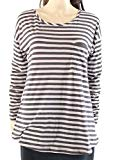

ASIN : B072M4ZF89
title : abound womens medium striped pocketfront knit top 24 brown 
Brand : Abound
Color : Brown
euclidean distance from input : 4.132935308883674


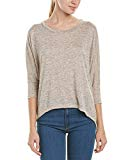

ASIN : B06ZZX46Z6
title : bobi womens bobi dolman top l brown 
Brand : Bobi
Color : Brown
euclidean distance from input : 4.133754485319145


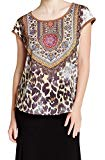

ASIN : B074VCLKJV
title : bobeau womens small abstract printed scoopneck blouse brown 
Brand : Bobeau
Color : Brown
euclidean distance from input : 4.134887331197746


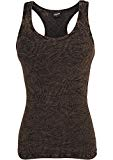

ASIN : B00BG0UJ40
title : urban classics womens crinkle camo tanktop xlarge brown 
Brand : CamoOutdoor
Color : Brown
euclidean distance from input : 4.135967754791267


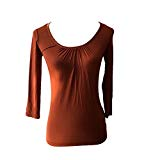

ASIN : B0718ZFSY7
title : boden brown scoop neck tunic top shirt tee size 2 
Brand : BODEN
Color : Brown
euclidean distance from input : 4.136068844268806


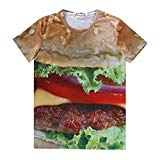

ASIN : B01CR325BE
title : catamaran hamburger shirt women harajuku short sleeve 3d tshirts xl 
Brand : Catamaran
Color : Brown
euclidean distance from input : 4.136487388084419


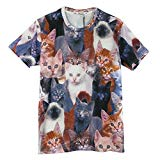

ASIN : B00OM4EF60
title : unisex hipster clothing cute cat cat shirt 3d short sleeve tshirt tee tops xl 
Brand : Moji
Color : Brown
euclidean distance from input : 4.13649027890969


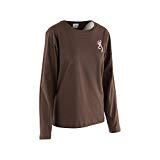

ASIN : B00NQFH7MA
title : browning womens buckmark ap pink classic long sleeve tee chocolate medium 
Brand : Browning
Color : Brown
euclidean distance from input : 4.1378376121025155


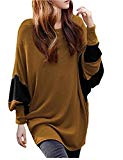

ASIN : B01L8TH6B2
title : taiduosheng women color block batwing loose tunic top 
Brand : Taiduosheng
Color : Brown
euclidean distance from input : 4.138801240394599


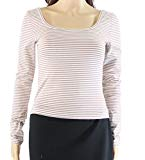

ASIN : B071FQX1CH
title : abound medium junior boat neck striped stretch knit top 24 brown 
Brand : Abound
Color : Brown
euclidean distance from input : 4.139878802965171


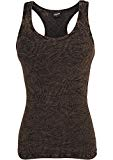

ASIN : B00BG0UIHI
title : urban classics ladies crinkle camo tanktop brown größemfarbebrown 
Brand : CamoOutdoor
Color : Brown
euclidean distance from input : 4.1409315700035165


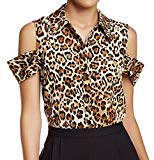

ASIN : B01M06V4X1
title : wayf womens small button leopard cold shoulder blouse brown 
Brand : WAYF
Color : Brown
euclidean distance from input : 4.142204069564826


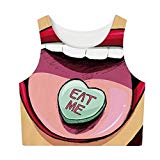

ASIN : B01HDKQ79M
title : dorathy womens summer crop top eat cartoon print kawaii sportswear vest tops 
Brand : Dorathy
Color : Brown
euclidean distance from input : 4.1438197428684305


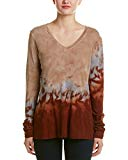

ASIN : B01N7V7SIG
title : xcvi womens top xs brown 
Brand : XCVI
Color : Brown
euclidean distance from input : 4.1449823314647745


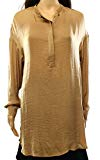

ASIN : B01L0T5PMW
title : ro  de bronze womens small henley highlow blouse brown 
Brand : Rode
Color : Brown
euclidean distance from input : 4.145120763252265


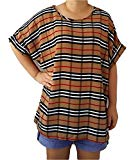

ASIN : B019EGEV9Q
title : trendyloosefit women plus size loose fit top shirt blouse bust 52 
Brand : Trendyloosefit
Color : Brown
euclidean distance from input : 4.14515002913285


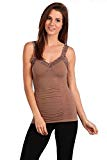

ASIN : B01CKFJ1ES
title : rena womens lace camisole pretty brown one size 
Brand : M. Rena
Color : Brown
euclidean distance from input : 4.14663820810128


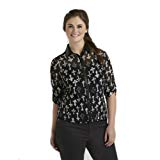

ASIN : B00K02DWJO
title : bongo juniors plus printed chiffon shirt  cross 1x 
Brand : Bongo
Color : brown
euclidean distance from input : 4.147657596538551


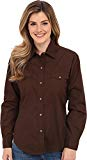

ASIN : B00JLQAOZ0
title : roper womens ls solid basic snap front brown buttonup shirt md 
Brand : Roper
Color : Brown
euclidean distance from input : 4.148167991111762


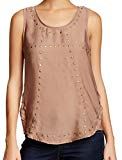

ASIN : B01M35MN7L
title : ro  de mocha womens small studded curvedhem blouse brown 
Brand : Rode
Color : Brown
euclidean distance from input : 4.14862429446984


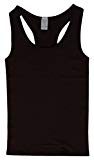

ASIN : B00JPOYCCO
title : teejoy womens seamless polyester racerback tank top one size  brown 
Brand : Sofra
Color : Brown
euclidean distance from input : 4.148689531753547


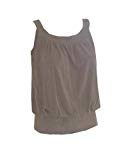

ASIN : B003SPYNAM
title : marrikas viscose bamboo ring top mushroom small 68 
Brand : Marrikas
Color : Brown
euclidean distance from input : 4.1534607643585275


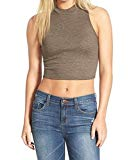

ASIN : B07288KFHF
title : soprano olive large junior cropped ribbed knit top 18 brown l 
Brand : Soprano
Color : Brown
euclidean distance from input : 4.15392323679734


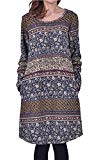

ASIN : B00NQR7GY2
title : womens retro tops ladies print scoop neck long sleeve dress 
Brand : Thenice
Color : Brown
euclidean distance from input : 4.1542582149009775


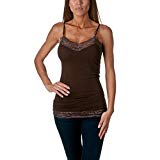

ASIN : B00RWB03MK
title : blvd womens lace trimmed long tank top brown small 
Brand : BLVD
Color : Brown
euclidean distance from input : 4.15806227273751


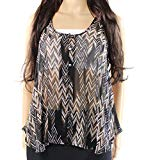

ASIN : B071LDTQ1F
title : hip small junior sheer printed button tank top 22 brown 
Brand : Hip
Color : Brown
euclidean distance from input : 4.159472399423606


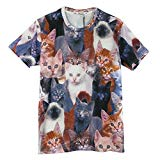

ASIN : B00OM4EH4K
title : unisex hipster clothing cute cat cat 3d short sleeve tshirt tee xxl 
Brand : Moji
Color : Brown
euclidean distance from input : 4.161272429893501


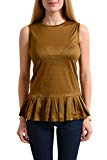

ASIN : B01EG15FVC
title : dsquared2 brown sleeveless womens peplum blouse top us 40 
Brand : DSQUARED2
Color : Brown
euclidean distance from input : 4.16180675573159


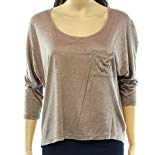

ASIN : B074MJN1K9
title : hip latter crochet back womens small hilow blouse brown 
Brand : Hip
Color : Brown
euclidean distance from input : 4.162010156581886


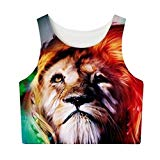

ASIN : B01HDKPMVQ
title : dorathy womens summer crop top tiger face 3d print kawaii sportswear vest top 
Brand : Dorathy
Color : Brown
euclidean distance from input : 4.163418822954185


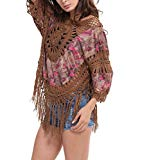

ASIN : B01CE40W16
title : marolaya womens caftan poncho tunic plus size sexy tassel cover 
Brand : Marolaya
Color : Brown
euclidean distance from input : 4.166394227216728


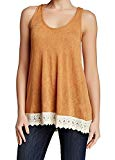

ASIN : B01MS8FD79
title : bobeau rust womens medium crochethem tank top brown 
Brand : Bobeau
Color : Brown
euclidean distance from input : 4.168966525266654


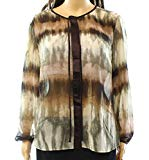

ASIN : B074QVMXSQ
title : bellatrix women large petite sheer button blouse brown pl 
Brand : bellatrix
Color : Brown
euclidean distance from input : 4.176313572595603


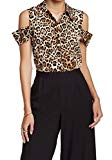

ASIN : B06XDPYJWG
title : wayf womens medium cold shoulder button blouse brown 
Brand : WAYF
Color : Brown
euclidean distance from input : 4.1763533288936685


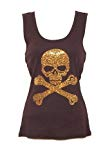

ASIN : B004YR55O6
title : crystal gold skull bone dark chocolate brown tank top 
Brand : stonepowerss
Color : Brown
euclidean distance from input : 4.180999242733009


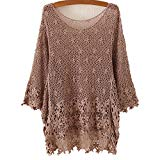

ASIN : B00ZC37KK8
title : crazy womens lace batwing sleeve shirt embroidery crochet blouse top tshirt 
Brand : Crazy
Color : Brown
euclidean distance from input : 4.181205176780708


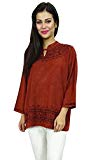

ASIN : B01MUHRUQK
title : women clothing long sleeves rayon top tunic embroiderd summer wear 
Brand : Ibaexports
Color : Brown
euclidean distance from input : 4.182613723943717


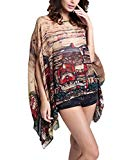

ASIN : B01CE40VX0
title : marolaya womens chiffon caftan poncho tunic floral plus size cover 
Brand : Marolaya
Color : Brown
euclidean distance from input : 4.185963087747581


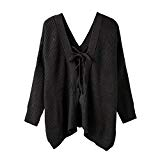

ASIN : B01LZJYZLH
title : abaday coffee vneck tie back long sleeve knit jumper 
Brand : ABADAY
Color : Brown
euclidean distance from input : 4.20015918559838


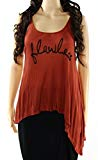

ASIN : B0758356K3
title : soprano womens small flawless asymmetric camisole top brown 
Brand : Soprano
Color : Brown
euclidean distance from input : 4.203341656396873


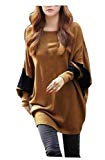

ASIN : B00GX7LR7O
title : ca fashion womens batwing sleeve color block tshirt top brown 
Brand : CA Fashion
Color : Brown
euclidean distance from input : 4.298007011413574


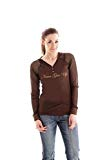

ASIN : B00S6W3MMW
title : cowgirl tuff western shirt womens ls henley hood xl brown h00340 
Brand : Cowgirl Tuff
Color : Brown
euclidean distance from input : 4.299177318811417


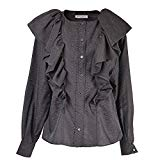

ASIN : B00LEHNVZ4
title : viktor  rolf womens wool brown snake print botton blouse us eu 40 
Brand : Viktor & Rolf
Color : Brown
euclidean distance from input : 4.300415188074112


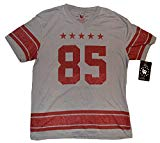

ASIN : B0145PNP1Q
title : lr vneck fashion tshirt gray burgundy numeral 85 front size xl 
Brand : L R
Color : Gray
euclidean distance from input : 4.301692485809326


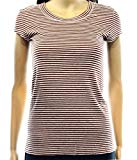

ASIN : B072BVB47Z
title : h bordeaux white womens small striped tee shirt brown 
Brand : H By Bordeaux
Color : Brown
euclidean distance from input : 4.31324177980423


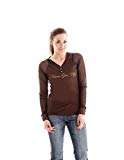

ASIN : B00Q42DVCW
title : cowgirl tuff western shirt women ls henley hood l rustic brown h00340 
Brand : Cowgirl Tuff
Color : Brown
euclidean distance from input : 4.3137772381305695


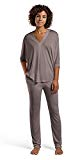

ASIN : B06Y3YRLP1
title : hanro womens leonie 34 sleeve shirt 76214 dim brown xsmall 
Brand : HANRO
Color : Dim Brown
euclidean distance from input : 4.315604120492935


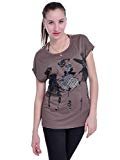

ASIN : B00BTJKAQ0
title : annakaci sm fit brown three fashion friends graphic print paisley panel top 
Brand : Anna-Kaci
Color : Brown
euclidean distance from input : 4.317041844129562


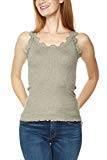

ASIN : B01MRM1P5H
title : rosemunde silk top regular wvintage lace brown melange xl 
Brand : Rosemunde
Color : Brown Melange
euclidean distance from input : 4.317927360534668


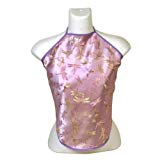

ASIN : B00BK9T7ZY
title : chinese dragonfly brocade halter tops  light purple  1 size fits du dou 
Brand : G'z
Color : Purple
euclidean distance from input : 4.319705933332443


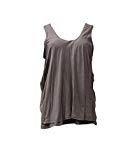

ASIN : B074GMGRJ7
title : inhabit womens supima cotton layered tank top sz l mushroom brown 50237pk 
Brand : Inhabit
Color : Mushroom Brown
euclidean distance from input : 4.32030126452446


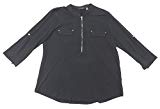

ASIN : B0718Y9J4M
title : fylo womens size large 12 zip 34 sleeve dress shirt black 
Brand : f
Color : Black
euclidean distance from input : 4.320997774600983


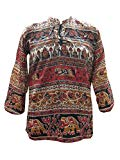

ASIN : B06XYZT4DL
title : mogul womens hippy brown tunic elephant print cotton top large 
Brand : Mogul Interior
Color : Brown
euclidean distance from input : 4.323179990053177


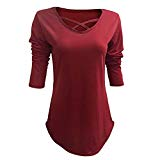

ASIN : B0711KH9DX
title : hn long sleeve shirts women casual blouse top floral xl red 
Brand : H&N
Color : Red
euclidean distance from input : 4.323328465223312


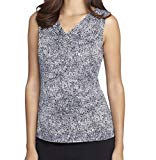

ASIN : B0754QB2HW
title : tahari asl women sleeveless vneck stretch tank top brown xl 
Brand : Tahari ASL
Color : Brown
euclidean distance from input : 4.323859423398972


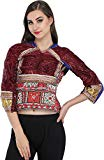

ASIN : B07573G52R
title : exotic india chocolate brown backless choli kutch antiquated rabari em 
Brand : Exotic India
Color : Brown
euclidean distance from input : 4.325873166322708


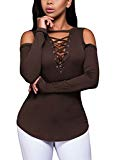

ASIN : B01HAFQ5S8
title : sarin mathews womens sexy v neck cutout long sleeve laceup bolero ribbed tops brown 
Brand : Sarin Mathews
Color : Brown
euclidean distance from input : 4.326257914304733


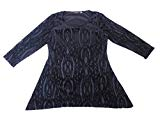

ASIN : B073HJRP1D
title : fylo london womens size small 34 sleeve blouse black 
Brand : f
Color : Black
euclidean distance from input : 4.327125132083893


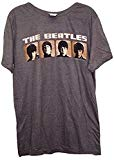

ASIN : B0738L39R2
title : beatles faces brown juniorwomens tshirt new regular brown xlarge 
Brand : The Beatles
Color : Brown
euclidean distance from input : 4.328373551368713


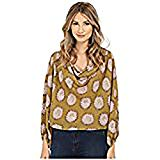

ASIN : B0154SCUWI
title : free people womens printed cowling around top godlenrod combo blouse lg 
Brand : Free People
Color : Brown
euclidean distance from input : 4.3297430872917175


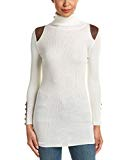

ASIN : B074RNZRX7
title : beulah womens beulah turtleneck top sm white 
Brand : Beulah
Color : Cream/Brown
euclidean distance from input : 4.3304252326488495


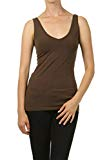

ASIN : B00WQ91IG8
title : rena reversible vneck  scoop neck tank  one size fits dark brown 
Brand : M. Rena
Color : Dark Brown
euclidean distance from input : 4.332206726074219


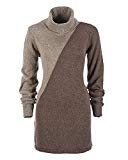

ASIN : B071YS6F8F
title : coco  carmen womens cast shadow sweater tunic brown sm 
Brand : Coco + Carmen
Color : Brown
euclidean distance from input : 4.332675188779831


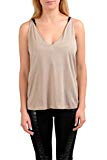

ASIN : B01MYOWN16
title : maison margiela 4 silk brown spaghetti straps womens blouse top us 42 
Brand : Maison Margiela
Color : Brown
euclidean distance from input : 4.332972407341003


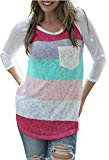

ASIN : B06XK2ZRFH
title : acquaa womens long sleeve stripe pocket fashion tshirt picture 
Brand : Acquaa
Color : Y#4
euclidean distance from input : 4.334618389606476


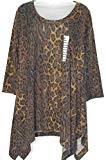

ASIN : B01BCRCYBW
title : premise ladies small sharkbite design long sleeve printed tunic espresso brown 
Brand : Premise
Color : Espresso Brown
euclidean distance from input : 4.336921721696854


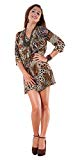

ASIN : B017YBAI9A
title : 1 world sarongs womens animal print tunic coverup small 
Brand : La Fleva
Color : Brown
euclidean distance from input : 4.337241053581238


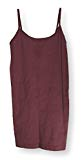

ASIN : B01DAW0PBS
title : hidden lotus womens seamless cami one size brown 
Brand : Hidden Lotus
Color : Brown
euclidean distance from input : 4.338366121053696


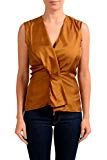

ASIN : B074FW26VT
title : maison margiela 4 100 silk brown womens sleeveless blouse us 40 
Brand : Maison Margiela
Color : Brown
euclidean distance from input : 4.338851183652878


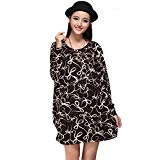

ASIN : B016MGC5VW
title : vogue code bows print long sleeve base shirt loose fit plus size blouse 
Brand : VOGUE CODE
Color : Brown
euclidean distance from input : 4.341419100761414


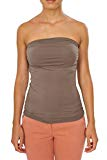

ASIN : B073ZCN5LG
title : brunello cucinelli top womens brown slim fit cotton casual xs 
Brand : Brunello Cucinelli
Color : Brown
euclidean distance from input : 4.341605454683304


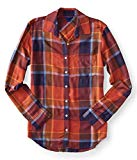

ASIN : B073S64DQC
title : aeropostale womens long sleeve plaid woven shirt harvest brown 
Brand : Aeropostale
Color : Harvest Brown
euclidean distance from input : 4.34224060177803


In [68]:
idf_w2v_brand_color_image(12566, 1, 3, 10, 100)

## Observations
* Recommendations with no weghtages and more weightage to image looks bettere
* Similarity using more weightage to idf w2v does not give more accurate results as compared to similarity with image features